In [1]:
## Figure 06 & Table 01 - Comparing InSAR Time-series with GPS Time-series

import os
import sys
import time
import datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt, ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
from pysar.simulation.plot import *
from pysar.objects import timeseries, ifgramStack, sensor, giantTimeseries
from pysar.utils import readfile, ptime, plot as pp, writefile, utils as ut, network as pnet
from pysar.objects.gps import GPS
from pysar import view

work_dir = os.path.expanduser('~/development/python/2018_ComputGeosci_PySAR/insar_vs_gps')
os.chdir(work_dir)
print('Go to directory: '+work_dir)
gps_dir = os.path.expanduser('~/insarlab/Galapagos/GPS')
gps_site_list_file = os.path.join(gps_dir, 'DataHoldings.txt')

site_r = 'GV01' #'TOUO' #'ISCO'  'GV01'  'GV07'  None

pysar_dir = '~/insarlab/Galapagos/GalapagosSenDT128/PYSAR'                # 5-conn stack
#pysar_dir = '~/insarlab/Galapagos/GalapagosSenDT128/PYSAR_IW1_10CONN'    # 10-conn stack
pysar_dir = os.path.expanduser(pysar_dir)
ts_file = os.path.join(pysar_dir, 'timeseries_ECMWF_ramp_demErr.h5')
ts_obj = timeseries(ts_file)
unit_fac = 1.

#ts_file = os.path.join(pysar_dir, '../GIANT/Stack/LS-PARAMS.h5')
##ts_file = os.path.join(pysar_dir, '../GIANT/Stack/TS-PARAMS.h5')
#ts_obj = giantTimeseries(ts_file)
#unit_fac = 0.001

geom_file = os.path.join(pysar_dir, 'INPUTS/geometryRadar.h5')
ts_obj.open(print_msg=False)
atr = ts_obj.metadata

temp_coh_file = os.path.join(pysar_dir, 'temporalCoherence.h5')
temp_coh = readfile.read(temp_coh_file)[0]

t0 = ts_obj.times[0] - relativedelta(months=2)
t1 = ts_obj.times[-1] + relativedelta(months=2)
start_date = t0.strftime('%Y%m%d')
end_date = t1.strftime('%Y%m%d')
start_date = '20141101'
end_date = '20180625'

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/insar_vs_gps


In [2]:
## 1. read GPS data
from scipy.interpolate import griddata

ds = {}
sname_list = ['GV{:02d}'.format(i) for i in [1] + np.arange(3,11).tolist()]
num_site = len(sname_list)

for sname in sname_list:
    site = {}
    site['name'] = sname
    gps_obj = GPS(sname, data_dir=gps_dir)
    gps_obj.open(print_msg=False)
    site['lat'] = gps_obj.site_lat
    site['lon'] = gps_obj.site_lon
    (site['gps_datetime'],
     site['gps_dis'],
     site['gps_std']) = gps_obj.read_gps_los_displacement(geom_file, start_date, end_date,
                                                          ref_site=site_r,
                                                          gps_comp='enu2los')[0:3]
    site['reference_site'] = site_r
    ds[sname] = site
    sys.stdout.write('\r{}'.format(sname))
    sys.stdout.flush()
print('\nDone.')

GV10
Done.


In [4]:
## 2. read InSAR data with interpolation
# 2.1 prepare interpolation
coord = ut.coordinate(atr, lookup_file=geom_file)
num_date = ts_obj.numDate
lats = [ds[k]['lat'] for k in ds.keys()]
lons = [ds[k]['lon'] for k in ds.keys()]
geo_box = (min(lons), max(lats), max(lons), min(lats))     #(W, N, E, S)
pix_box = coord.bbox_geo2radar(geo_box)     #(400, 1450, 550, 1600)
src_lat = readfile.read(geom_file, datasetName='latitude', box=pix_box)[0].reshape(-1,1)
src_lon = readfile.read(geom_file, datasetName='longitude', box=pix_box)[0].reshape(-1,1)
src_pts = np.hstack((src_lat, src_lon))
src_value = readfile.read(ts_file, box=pix_box)[0].reshape(num_date, -1)

dest_pts = np.zeros((num_site, 2))
for i in range(num_site):
    site = ds[sname_list[i]]
    dest_pts[i,:] = site['lat'], site['lon']

# 2.2 interpolation
interp_method = 'linear'   #nearest, linear, cubic
dest_value = np.zeros((num_site, num_date))
for i in range(num_date):
    dest_value[:,i] = griddata(src_pts, src_value[i,:], dest_pts, method=interp_method)
    sys.stdout.write('\r{}/{}'.format(i+1, num_date))
    sys.stdout.flush()
print()

# 2.3 write interpolation result
insar_dis_name = 'insar_dis_{}'.format(interp_method)
insar_dis_ref = dest_value[sname_list.index(site_r),:]
for i in range(num_site):
    site = ds[sname_list[i]]
    site['insar_datetime'] = ts_obj.times
    # reference insar to the precise location in space
    site[insar_dis_name] = dest_value[i,:] - insar_dis_ref
    # grab temporal coherence value
    y, x = coord.geo2radar(site['lat'], site['lon'], print_msg=False)[0:2]
    temp_coh = readfile.read(temp_coh_file, box=(x, y, x+1, y+1))[0]
    site['temp_coh'] = temp_coh.flatten()[0]

# 2.4 reference insar and gps to a common date
for i in range(num_site):
    site = ds[sname_list[i]]
    gps_date = site['gps_datetime']
    insar_date = site['insar_datetime']

    # find common reference date
    idx = 5
    while idx < num_date:
        if insar_date[idx] not in gps_date:
            idx += 1
        else:
            break
    if idx == num_date:
        raise RuntimeError('InSAR and GPS do not share ANY date for site: {}'.format(site['name']))
    comm_date = insar_date[idx]
    # reference insar in time
    site[insar_dis_name] -= site[insar_dis_name][idx]
    # reference gps dis/std in time
    idx_gps = np.where(gps_date == comm_date)[0][0]
    site['gps_dis'] -= site['gps_dis'][idx_gps]
    site['gps_std'] = np.sqrt(site['gps_std']**2 + site['gps_std'][idx_gps]**2)
    site['gps_std_mean'] = np.mean(site['gps_std'])
print('Done.')

98/98
Done.


In [25]:
## 3. calculate RMSE
for i in range(num_site):
    site = ds[sname_list[i]]
    gps_date = site['gps_datetime']
    insar_date = site['insar_datetime']
    comm_dates = np.array(sorted(list(set(gps_date) & set(insar_date))))
    num_comm_date = len(comm_dates)

    # get displacement at common dates
    comm_dis_insar = np.zeros(num_comm_date, np.float32)
    comm_dis_gps   = np.zeros(num_comm_date, np.float32)
    for j in range(num_comm_date):
        idx1 = np.where(gps_date   == comm_dates[j])[0][0]
        idx2 = np.where(insar_date == comm_dates[j])[0][0]
        comm_dis_gps[j]   = site['gps_dis'][idx1]
        comm_dis_insar[j] = site[insar_dis_name][idx2]
    site['comm_dis_gps'] = comm_dis_gps
    site['comm_dis_insar'] = comm_dis_insar
    site['r2square'] = stats.linregress(comm_dis_gps, comm_dis_insar)[2]
    site['dis_rmse'] = np.sqrt(np.sum(np.square(comm_dis_gps - comm_dis_insar)) / (num_comm_date - 1))
    #print('site: {}, RMSE: {:.1f} cm'.format(sname_list[i], dis_rmse*100.))

## 4. calculate velocity to sort plotting order
site_vel = {}
for i in range(num_site):
    site = ds[sname_list[i]]
    # design matrix
    yr_diff = np.array([i.year + (i.timetuple().tm_yday - 1) / 365.25 for i in site['insar_datetime']])
    yr_diff -= yr_diff[0]
    A = np.ones([len(site['insar_datetime']), 2], dtype=np.float32)
    A[:, 0] = yr_diff
    # LS estimation
    ts = np.array(site[insar_dis_name])
    ts -= ts[0]
    X = np.dot(np.linalg.pinv(A), ts)[0]
    site_vel[sname_list[i]] = X
sname_list2plot = [i[0] for i in sorted(site_vel.items(), key=lambda kv: kv[1], reverse=True)]
sname_list2plot = [i for i in sname_list2plot if site_vel[i] != 0]
print('Done.')

Done.


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [28]:
## STATS Check
for sname in sname_list:
    site = ds[sname]
    print('{}: InSAR RMSE: {:.1f}, GPS STD*3: {:.1f}, R-square: {:.2f}'.format(site['name'],
                                                                               site['dis_rmse']*100.,
                                                                               site['gps_std_mean']*3.*100.,
                                                                               site['r2square']))
print('Done.')

GV01: InSAR RMSE: 0.0, GPS STD*3: 1.0, R-square: 0.00
GV03: InSAR RMSE: 0.9, GPS STD*3: 1.4, R-square: 1.00
GV04: InSAR RMSE: 0.5, GPS STD*3: 1.0, R-square: 1.00
GV05: InSAR RMSE: 1.4, GPS STD*3: 1.0, R-square: 1.00
GV06: InSAR RMSE: 0.7, GPS STD*3: 1.0, R-square: 1.00
GV07: InSAR RMSE: 0.6, GPS STD*3: 1.0, R-square: 1.00
GV08: InSAR RMSE: 1.1, GPS STD*3: 1.0, R-square: 1.00
GV09: InSAR RMSE: 1.8, GPS STD*3: 1.0, R-square: 1.00
GV10: InSAR RMSE: 3.9, GPS STD*3: 1.0, R-square: 0.72
Done.


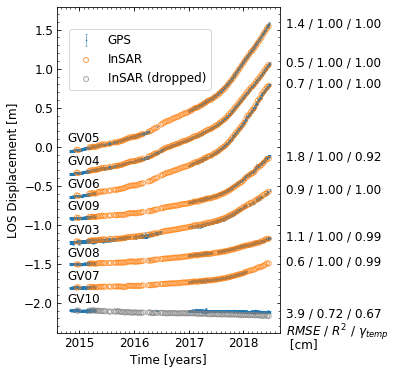

In [48]:
## Figure 6 (b) - Displacement Time-series from InSAR and GPS
def plot_ts(ax, site, offset=0.):
    # GPS
    ax.errorbar(site['gps_datetime'],
                site['gps_dis']-offset,
                yerr=site['gps_std']*3.,
                ms=marker_size*0.2, lw=0, alpha=1., fmt='-o',
                elinewidth=edge_width*0.5, ecolor=pp.mplColors[0],
                capsize=marker_size*0.25, markeredgewidth=edge_width*0.5,
                label='GPS', zorder=1)
    # InSAR
    if site['temp_coh'] < 0.7:
        ecolor = 'gray'
    else:
        ecolor = pp.mplColors[1]
    ax.scatter(site['insar_datetime'],
               site[insar_dis_name]-offset,
               s=5**2, label='InSAR',
               facecolors='none', edgecolors=ecolor, linewidth=1., alpha=0.7, zorder=2)
    # Label
    ax.annotate('{:.1f} / {:.2f} / {:.2f}'.format(site['dis_rmse']*100., site['r2square'], site['temp_coh']),
                xy=(1.03, site[insar_dis_name][-1] - offset - 0.02),
                xycoords=ax.get_yaxis_transform(),  # y in data untis, x in axes fraction
                color='k', fontsize=font_size)
    ax.annotate('{}'.format(site['name']),
                xy=(0.05, site[insar_dis_name][0] - offset + 0.1),
                xycoords=ax.get_yaxis_transform(),  # y in data untis, x in axes fraction
                color='k', fontsize=font_size)
    return ax

fig, ax = plt.subplots(figsize=(4, 6))
for i in range(len(sname_list2plot)):
    site = ds[sname_list2plot[i]]
    ax = plot_ts(ax, site, offset=0.3*i)

ax = pp.auto_adjust_xaxis_date(ax, ts_obj.yearList)[0]
ax.set_xlabel('Time [years]', fontsize=font_size)
ax.set_ylabel('LOS Displacement [m]', fontsize=font_size)
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
#ax.annotate('Temp Coherence\nRMSE [cm]', xy=(0.03, 0.65), xycoords='axes fraction', fontsize=font_size, color='k')
ax.annotate(r'$RMSE$ / $R^2$ / $\gamma_{temp}$', xy=(1.03, -0.01), xycoords='axes fraction', fontsize=font_size, color='k')
ax.annotate(' [cm]', xy=(1.03, -0.045), xycoords='axes fraction', fontsize=font_size, color='k')
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[-1], handles[0], handles[int(len(handles)/2-1)]],
          ['GPS', 'InSAR', 'InSAR (dropped)'],
          loc='upper left', bbox_to_anchor=(0.03, 0.95), fontsize=font_size)
plt.savefig('insar_vs_gps_point_ts.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

view.py /Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE/geo_timeseries_ECMWF_ramp_demErr.h5 20180619 --ref-date 20141213 --dem /Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE/../../DEM/demLat_S02_N01_Lon_W092_W090.dem.wgs84 --dem-nocontour -m /Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE/geo_maskTempCoh.h5 --sub-lat -0.86 -0.77 --sub-lon -91.19 -91.07 -u m --vlim -0.4 2.5 --lalo-step 0.05 --lalo-loc 1 0 1 0 --scalebar 0.2 0.85 0.05 --fontsize 12 --notitle --dpi 600 --cbar-nbins 4 --cbar-ext both --nomultilook --show-gps --gps-comp enu2los --ref-gps GV01 


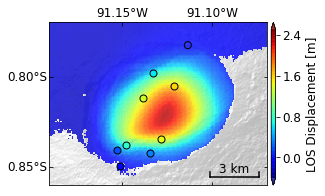

In [89]:
## Figure 6 (a) - InSAR velocity map with GPS location on Sierra Negra
pysar_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE'
vel_file  = os.path.join(pysar_dir, 'geo_velocity_masked.h5')
dem_file  = os.path.join(pysar_dir, '../../DEM/demLat_S02_N01_Lon_W092_W090.dem.wgs84')
ts_file   = os.path.join(pysar_dir, 'geo_timeseries_ECMWF_ramp_demErr.h5')

print_msg = False
fig, ax = plt.subplots(figsize=(5, 3))
# call view.py functions to plot InSAR background
cmd  = 'view.py {} 20180619 --ref-date 20141213 --dem {} --dem-nocontour '.format(ts_file, dem_file)
cmd += '--sub-lat -0.86 -0.77 --sub-lon -91.19 -91.07 -u m --vlim -0.4 2.5 '
cmd += '--lalo-step 0.05 --lalo-loc 1 0 1 0 --scalebar 0.2 0.85 0.05 '
cmd += '--fontsize 12 --notitle --dpi 600 '
cmd += '--cbar-nbins 4 --cbar-ext both --nomultilook '
cmd += '--show-gps --gps-comp enu2los --ref-gps GV01 '
print(cmd)
d_v, atr, inps = view.prep_slice(cmd, print_msg=print_msg)
inps.cbar_label = 'LOS Displacement [m]'
ax, inps, im, cbar = view.plot_slice(ax, d_v, atr, inps, print_msg=print_msg)
plt.savefig('insar_vs_gps_map.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

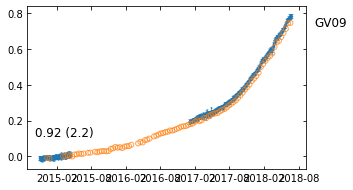

In [102]:
## plot single station timeseries - InSAR vs GPS
site = ds['GV09']
fig, ax = plt.subplots(figsize=(5, 3))
ax = plot_ts(ax, site, offset=0)
ax.tick_params(which='both', direction='in', top=True, bottom=True, left=True, right=True)
#plt.savefig('{}-{}.jpg'.format(site, site_r), bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

lat/lon: -0.7824/-91.1134, y/x: 1464/466
lat/lon: -0.7978/-91.1329, y/x: 1494/494
lat/lon: -0.8115/-91.1381, y/x: 1517/498
lat/lon: -0.8049/-91.1212, y/x: 1501/472
lat/lon: -0.8343/-91.1281, y/x: 1549/472
lat/lon: -0.8405/-91.1526, y/x: 1566/512
lat/lon: -0.8420/-91.1344, y/x: 1563/481
lat/lon: -0.8373/-91.1474, y/x: 1560/504
lat/lon: -0.8493/-91.1510, y/x: 1579/506


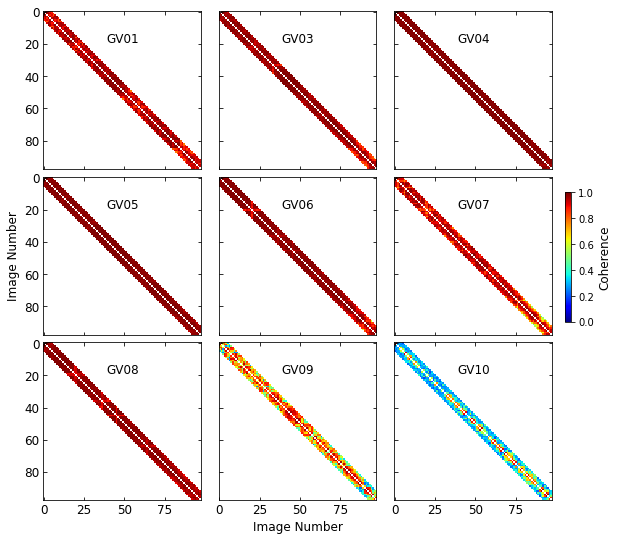

Done.


In [33]:
## Figure S3 - Coherence Matrix of InSAR observation on GPS sites

def get_site_coherence_matrix(site='GV01'):
    gps_obj = gps(site, data_dir=gps_dir)
    gps_obj.open(print_msg=False)

    ifg_file = os.path.join(pysar_dir, 'INPUTS/ifgramStack.h5')
    geom_file = os.path.join(pysar_dir, 'INPUTS/geometryRadar.h5')
    stack_obj = ifgramStack(ifg_file)
    stack_obj.open(print_msg=False)
    date12_list_all = stack_obj.get_date12_list(dropIfgram=True)

    coord = ut.coordinate(stack_obj.metadata, lookup_file=geom_file)
    y, x = coord.geo2radar(gps_obj.site_lat, gps_obj.site_lon, print_msg=False)[0:2]
    box = (x, y, x+1, y+1)
    dset_list = ['coherence-{}'.format(i) for i in date12_list_all]
    coh = np.squeeze(readfile.read(ifg_file, datasetName=dset_list, box=box, print_msg=False)[0])

    print('lat/lon: {:.4f}/{:.4f}, y/x: {}/{}'.format(gps_obj.site_lat, gps_obj.site_lon, y, x))

    coh_date12_list = list(np.array(date12_list_all)[np.array(coh) >= 0.25])
    date12_to_drop = sorted(list(set(date12_list_all) - set(coh_date12_list)))

    coh_mat = pnet.coherence_matrix(date12_list_all, coh.tolist())

    A = stack_obj.get_design_matrix4timeseries_estimation(date12_list = coh_date12_list)[0]
    if np.linalg.matrix_rank(A) < A.shape[1]:
        print('Singular design matrix!')
    return coh_mat

gps_sites = ['GV{:02d}'.format(i) for i in [1] + np.arange(3,11).tolist()]
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=[9, 9], sharex=True, sharey=True)
for i in range(len(gps_sites)):
    ax = axs.flatten()[i]
    site = gps_sites[i]
    coh_mat = get_site_coherence_matrix(site)
    im = ax.imshow(coh_mat, cmap='jet', vmin=0., vmax=1.)
    ax.tick_params(which='both', direction='in', labelsize=font_size,
                   bottom=True, top=True, left=True, right=True)
    ax.annotate(site, xy=(0.4, 0.8), color='k', xycoords='axes fraction', fontsize=font_size)
axs[1,0].set_ylabel('Image Number', fontsize=font_size)
axs[2,1].set_xlabel('Image Number', fontsize=font_size)

# colorbar
fig.subplots_adjust(right=0.93)
cax = fig.add_axes([0.94, 0.4, 0.01, 0.2])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Coherence', fontsize=font_size)

fig.subplots_adjust(wspace=0.03, hspace=0.05)
plt.savefig('insar_vs_gps_coh_mat.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()
print('Done.')

In [ ]:
## Table 1 - RMSE of InSAR relative to GPS
## PySAR with stack of 5 conns
site: 'GV05-GV01', temp_coh: 0.9582, rmse: 1.5967 cm
site: 'GV04-GV01', temp_coh: 0.9595, rmse: 0.6137 cm
site: 'GV06-GV01', temp_coh: 0.9503, rmse: 2.3160 cm
site: 'GV09-GV01', temp_coh: 0.9135, rmse: 3.1752 cm
site: 'GV03-GV01', temp_coh: 0.9399, rmse: 0.7542 cm
site: 'GV08-GV01', temp_coh: 0.9544, rmse: 2.3633 cm
site: 'GV07-GV01', temp_coh: 0.9414, rmse: 1.0308 cm
site: 'GV10-GV01', temp_coh: 0.6908, rmse: 2.7034 cm

## PySAR with stack of 10 conns
site: 'GV05-GV01', temp_coh: 0.9980, rmse: 1.3407 cm
site: 'GV04-GV01', temp_coh: 0.9987, rmse: 0.5663 cm
site: 'GV06-GV01', temp_coh: 0.9985, rmse: 2.2822 cm
site: 'GV09-GV01', temp_coh: 0.9350, rmse: 2.2621 cm
site: 'GV03-GV01', temp_coh: 0.9947, rmse: 0.8842 cm
site: 'GV08-GV01', temp_coh: 0.9978, rmse: 2.0998 cm
site: 'GV07-GV01', temp_coh: 0.9952, rmse: 0.8871 cm
site: 'GV10-GV01', temp_coh: 0.6029, rmse: 1.6727 cm

## G-SBAS (temp_coh from pysar-5conns)
site: 'GV05-GV01', temp_coh: 0.9582, rmse: 1.4072 cm
site: 'GV04-GV01', temp_coh: 0.9595, rmse: 0.5512 cm
site: 'GV06-GV01', temp_coh: 0.9503, rmse: 2.1117 cm
site: 'GV09-GV01', temp_coh: 0.9135, rmse: nan cm
site: 'GV03-GV01', temp_coh: 0.9399, rmse: 0.7156 cm
site: 'GV08-GV01', temp_coh: 0.9544, rmse: 2.2773 cm
site: 'GV07-GV01', temp_coh: 0.9414, rmse: 1.0928 cm
site: 'GV10-GV01', temp_coh: 0.6908, rmse: nan cm

## G-TimeFun (temp_coh from pysar-5conns)
site: 'GV05-GV01', temp_coh: 0.9582, rmse: 1.1000 cm
site: 'GV04-GV01', temp_coh: 0.9595, rmse: 0.9780 cm
site: 'GV06-GV01', temp_coh: 0.9503, rmse: 1.1395 cm
site: 'GV09-GV01', temp_coh: 0.9135, rmse: nan cm
site: 'GV03-GV01', temp_coh: 0.9399, rmse: 1.1601 cm
site: 'GV08-GV01', temp_coh: 0.9544, rmse: 0.9807 cm
site: 'GV07-GV01', temp_coh: 0.9414, rmse: 0.7764 cm
site: 'GV10-GV01', temp_coh: 0.6908, rmse: nan cm

## PySAR with stack of ------------ 5 conns --------------------- 10 conns -------------
site: GV03, temp_coh: 1.00, rmse: 0.8 cm | site: GV03, temp_coh: 0.99, rmse: 0.9 cm
site: GV04, temp_coh: 1.00, rmse: 0.7 cm | site: GV04, temp_coh: 1.00, rmse: 0.8 cm
site: GV05, temp_coh: 1.00, rmse: 1.8 cm | site: GV05, temp_coh: 1.00, rmse: 1.7 cm
site: GV06, temp_coh: 1.00, rmse: 2.5 cm | site: GV06, temp_coh: 1.00, rmse: 2.7 cm
site: GV07, temp_coh: 0.99, rmse: 1.0 cm | site: GV07, temp_coh: 1.00, rmse: 1.0 cm
site: GV08, temp_coh: 0.99, rmse: 2.3 cm | site: GV08, temp_coh: 1.00, rmse: 2.2 cm
site: GV09, temp_coh: 0.92, rmse: 3.4 cm | site: GV09, temp_coh: 0.93, rmse: 2.5 cm
site: GV10, temp_coh: 0.67, rmse: 3.0 cm | site: GV10, temp_coh: 0.60, rmse: 1.7 cm